# Dengue Prediction Model Training & Analysis (Thesis Version)
This notebook covers the end-to-end modeling process for the Dengue Early Warning System.
It includes:
1.  **Exploratory Data Analysis (EDA)**: Distributions, Seasonality, Correlations.
2.  **Statistical Modeling**: SARIMA (Baseline).
3.  **Machine Learning**: XGBoost (Advanced).
4.  **Evaluation**: Regression Metrics (RMSE, R²) and Classification Metrics (ROC for Outbreak Detection).
5.  **Validation**: Time-Series Split Strategy.

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, roc_curve, auc, confusion_matrix, classification_report
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

## 1. Data Loading & Overview

In [2]:
# Load Data
try:
    df_awareness = pd.read_csv('awareness_score.csv')
    df_dengue = pd.read_csv('dengue.csv')
    
    # Preprocess Date
    df_dengue['Date'] = pd.to_datetime(df_dengue['Year'].astype(str) + '-' + df_dengue['Month No'].astype(str) + '-01')
    
    print("Data Loaded Successfully")
except FileNotFoundError:
    print("Error: Data files not found.")

Data Loaded Successfully


## 2. Exploratory Data Analysis (EDA) for Thesis

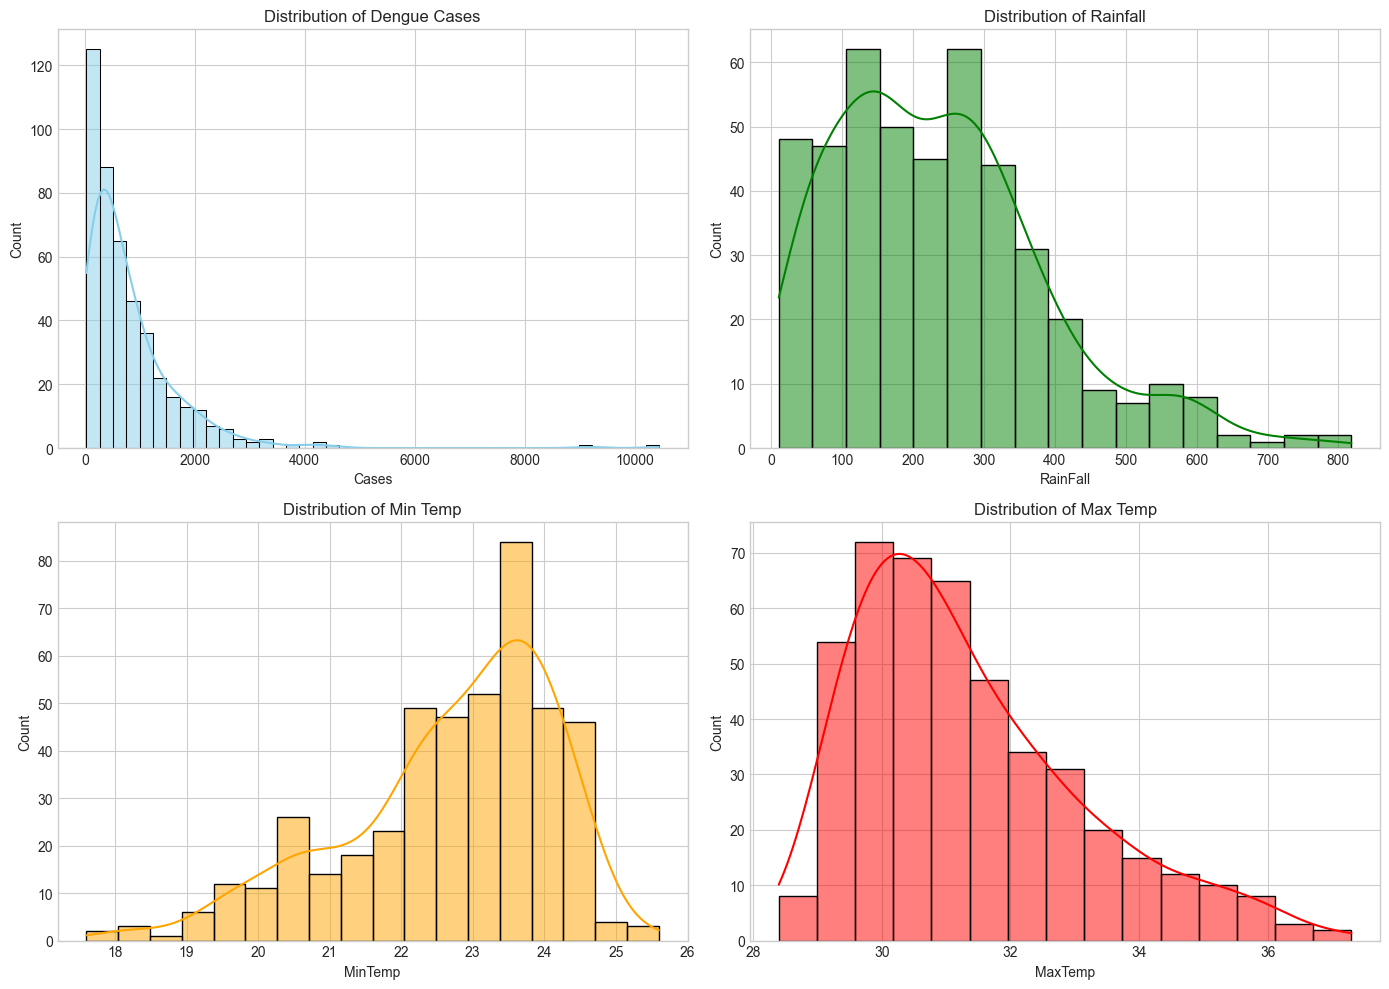

In [3]:
# 2.1 Distribution of Key Variables
if 'df_dengue' in locals():
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    sns.histplot(df_dengue['Cases'], kde=True, ax=axes[0, 0], color='skyblue')
    axes[0, 0].set_title('Distribution of Dengue Cases')
    
    sns.histplot(df_dengue['RainFall'], kde=True, ax=axes[0, 1], color='green')
    axes[0, 1].set_title('Distribution of Rainfall')
    
    sns.histplot(df_dengue['MinTemp'], kde=True, ax=axes[1, 0], color='orange')
    axes[1, 0].set_title('Distribution of Min Temp')
    
    sns.histplot(df_dengue['MaxTemp'], kde=True, ax=axes[1, 1], color='red')
    axes[1, 1].set_title('Distribution of Max Temp')
    
    plt.tight_layout()
    plt.show()

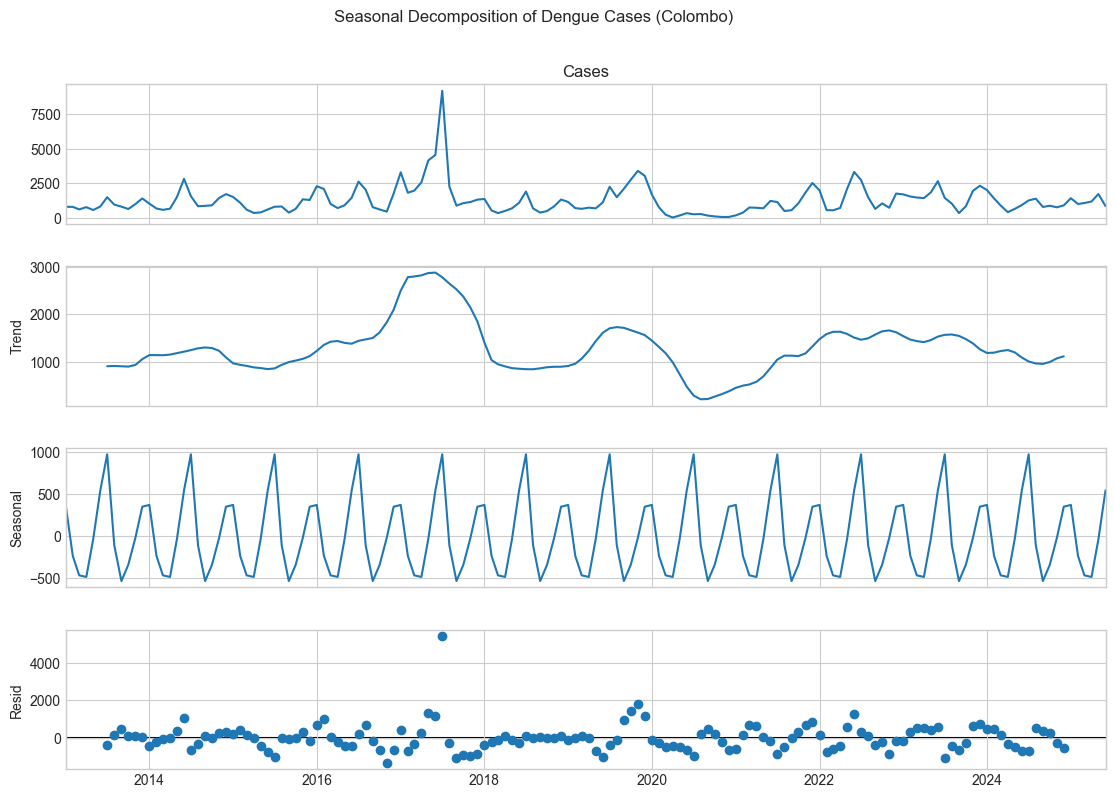

In [4]:
# 2.2 Seasonal Decomposition (Colombo District)
if 'df_dengue' in locals():
    colombo_df = df_dengue[df_dengue['District'] == 'Colombo'].set_index('Date').sort_index()
    
    decomposition = seasonal_decompose(colombo_df['Cases'], model='additive', period=12)
    fig = decomposition.plot()
    fig.set_size_inches(12, 8)
    plt.suptitle('Seasonal Decomposition of Dengue Cases (Colombo)', y=1.02)
    plt.show()

## 3. Statistical Modeling: SARIMA (Baseline)

Training SARIMA Model...


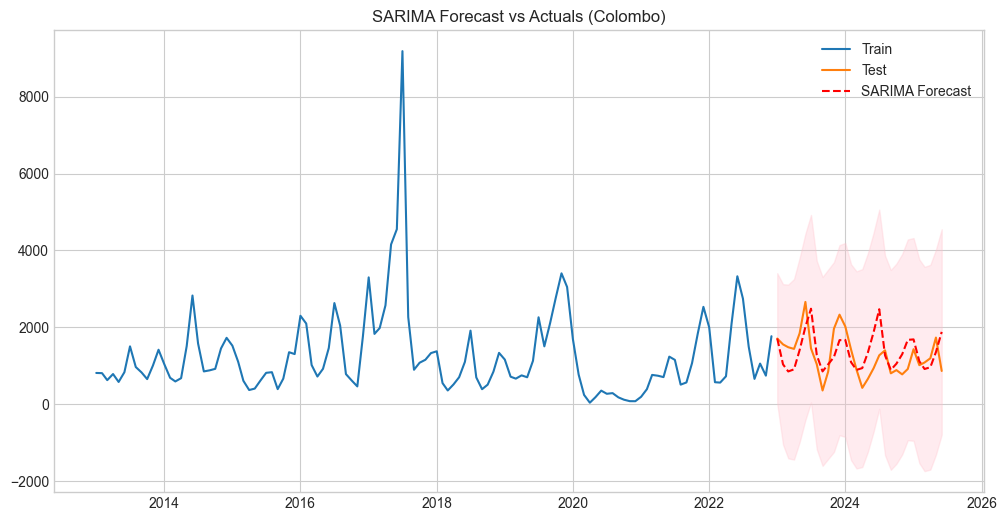

SARIMA Performance - RMSE: 562.01, R2: -0.11


In [5]:
# 3.1 SARIMA Implementation for Colombo
if 'colombo_df' in locals():
    # Split Train/Test
    train_size = int(len(colombo_df) * 0.8)
    train_sarima, test_sarima = colombo_df['Cases'][:train_size], colombo_df['Cases'][train_size:]
    
    # Fit SARIMA (Order selection would typically be automated, using (1,1,1)x(1,1,1,12) as example)
    print("Training SARIMA Model...")
    sarima_model = SARIMAX(train_sarima, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    sarima_result = sarima_model.fit(disp=False)
    
    # Forecast
    sarima_pred = sarima_result.get_forecast(steps=len(test_sarima))
    sarima_pred_mean = sarima_pred.predicted_mean
    sarima_conf_int = sarima_pred.conf_int()
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(train_sarima.index, train_sarima, label='Train')
    plt.plot(test_sarima.index, test_sarima, label='Test')
    plt.plot(test_sarima.index, sarima_pred_mean, label='SARIMA Forecast', color='red', linestyle='--')
    plt.fill_between(test_sarima.index, sarima_conf_int.iloc[:, 0], sarima_conf_int.iloc[:, 1], color='pink', alpha=0.3)
    plt.title('SARIMA Forecast vs Actuals (Colombo)')
    plt.legend()
    plt.show()
    
    # Evaluation
    sarima_rmse = np.sqrt(mean_squared_error(test_sarima, sarima_pred_mean))
    sarima_r2 = r2_score(test_sarima, sarima_pred_mean)
    print(f"SARIMA Performance - RMSE: {sarima_rmse:.2f}, R2: {sarima_r2:.2f}")

## 4. Machine Learning: XGBoost (Advanced)

In [6]:
# 4.1 Feature Engineering (Same as before)
if 'df_dengue' in locals():
    # Calculate CDRI
    cdri_ref = df_awareness.groupby('district')['total_score'].mean().reset_index()
    cdri_ref.rename(columns={'total_score': 'CDRI', 'district': 'District'}, inplace=True)
    
    # Merge & Lag
    df_merged = pd.merge(df_dengue, cdri_ref, on='District', how='left')
    df_merged.sort_values(by=['District', 'Date'], inplace=True)
    
    lag_features = ['Cases', 'RainFall', 'MinTemp', 'MaxTemp']
    for feature in lag_features:
        df_merged[f'{feature}_Lag1'] = df_merged.groupby('District')[feature].shift(1)
        
    df_final = df_merged.dropna().reset_index(drop=True)

In [7]:
# 4.2 Train XGBoost
features = ['Cases_Lag1', 'RainFall_Lag1', 'MinTemp_Lag1', 'MaxTemp_Lag1', 'CDRI', 'Population', 'Month No']
target = 'Cases'

X = df_final[features]
y = df_final[target]

# Chronological Split
df_sorted_time = df_final[df_final['Date'].dt.year >= 2014].sort_values(by='Date').set_index('Date')
X_sorted = df_sorted_time[features]
y_sorted = df_sorted_time[target]

split_index = int(len(df_sorted_time) * 0.8)
X_train, X_test = X_sorted.iloc[:split_index], X_sorted.iloc[split_index:]
y_train, y_test = y_sorted.iloc[:split_index], y_sorted.iloc[split_index:]

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
xgb_r2 = r2_score(y_test, y_pred)
print(f"XGBoost Performance - RMSE: {xgb_rmse:.2f}, R2: {xgb_r2:.2f}")

XGBoost Performance - RMSE: 442.45, R2: 0.45


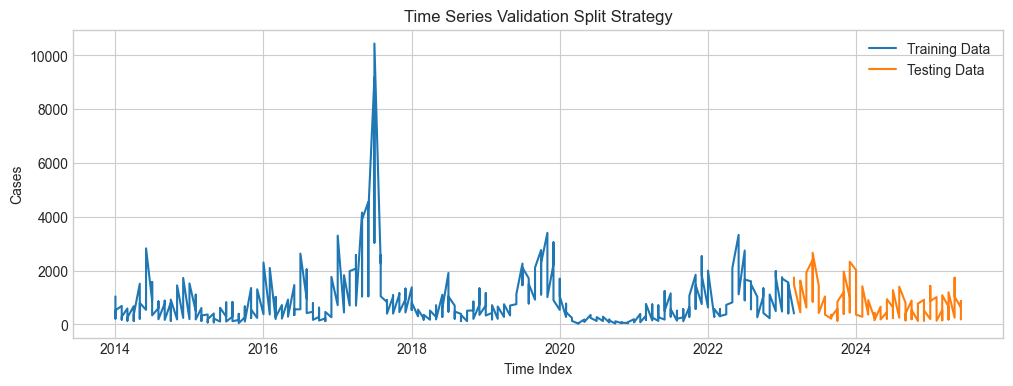

In [14]:
# 4.3 Validation Strategy Visualization
plt.figure(figsize=(12, 4))
plt.plot(y_train.index, y_train, label='Training Data')
plt.plot(y_test.index, y_test, label='Testing Data')
plt.title('Time Series Validation Split Strategy')
plt.xlabel('Time Index')
plt.ylabel('Cases')
plt.legend()
plt.show()

## 5. Model Evaluation & Comparison

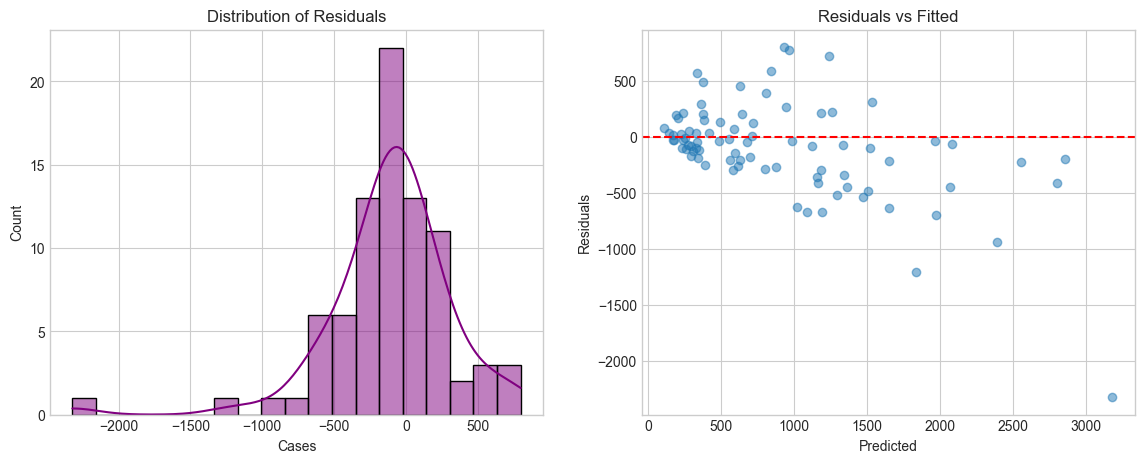

In [10]:
# 5.1 Residual Analysis (XGBoost)
residuals = y_test - y_pred

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(residuals, kde=True, ax=axes[0], color='purple')
axes[0].set_title('Distribution of Residuals')

axes[1].scatter(y_pred, residuals, alpha=0.5)
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residuals vs Fitted')

plt.show()

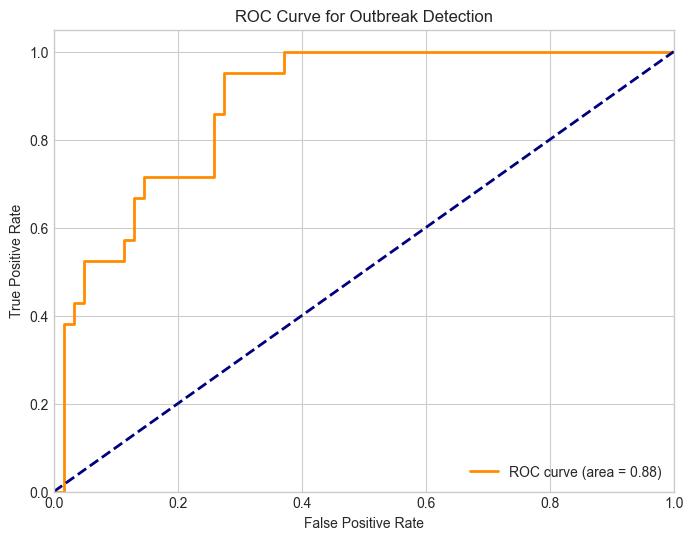

In [11]:
# 5.2 Outbreak Detection (ROC Curve)
# Define Outbreak: Cases > 75th percentile of historical data
threshold = np.percentile(y, 75)
y_test_binary = (y_test > threshold).astype(int)
y_pred_binary = (y_pred > threshold).astype(int)

# Calculate ROC
fpr, tpr, _ = roc_curve(y_test_binary, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Outbreak Detection')
plt.legend(loc="lower right")
plt.show()

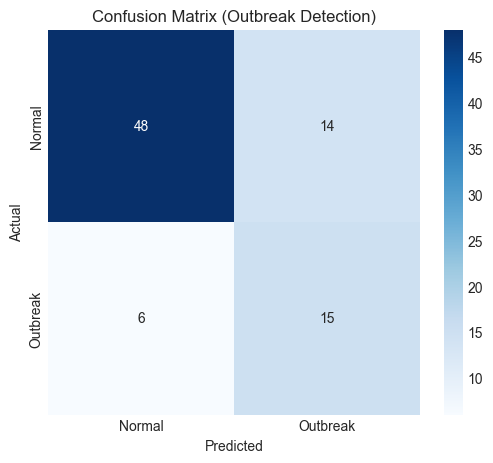

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.77      0.83        62
           1       0.52      0.71      0.60        21

    accuracy                           0.76        83
   macro avg       0.70      0.74      0.71        83
weighted avg       0.79      0.76      0.77        83



In [12]:
# 5.3 Confusion Matrix for Outbreaks
cm = confusion_matrix(y_test_binary, y_pred_binary)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Outbreak'], yticklabels=['Normal', 'Outbreak'])
plt.title('Confusion Matrix (Outbreak Detection)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print("Classification Report:")
print(classification_report(y_test_binary, y_pred_binary))

In [13]:
# 5.4 Save Final Artifacts
with open('dengue_model1.pkl', 'wb') as f:
    pickle.dump(model, f)
with open('cdri_ref1.pkl', 'wb') as f:
    pickle.dump(cdri_ref, f)
print("Final artifacts saved.")

Final artifacts saved.
